In [1]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import geopandas as gpd
from shapely.geometry import Point, mapping
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import cityImage as ci

In [2]:
city_name = 'London'
epsg = 27700
crs = {'init': 'epsg:'+str(epsg), 'no_defs': True}

### Download from OSM

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *OSMpolygon*, provide an OSM polygon (relation) name.
* *distance_from_address*, provide a precise address and define parameter "distance" (which is otherwise not necessary)

In [4]:
place = 'Greater London'
download_method = 'OSMplace'
distance = None

nodes_graph, edges_graph = ci.get_network_fromOSM(place, download_method, 'drive', epsg, distance = distance)
nodes_graph, edges_graph = ci.clean_network(nodes_graph, edges_graph, dead_ends = True, remove_disconnected_islands = True,
                            self_loops = True, same_uv_edges = True)

# saving
saving_path = 'Outputs/'+city_name+'/entireNetwork/'
nodes_graph.to_file(saving_path+city_name+"_nodes.shp", driver='ESRI Shapefile')
edges_graph.to_file(saving_path+city_name+"_edges.shp", driver='ESRI Shapefile')

### Load from local path (when already processed the network)

In [ ]:
input_path = 'Outputs/'+city_name+'/entireNetwork/'

nodes_graph = gpd.read_file(input_path+city_name+'_nodes.shp')
edges_graph = gpd.read_file(input_path+city_name+'_edges.shp')
nodesDual_graph = gpd.read_file(input_path+city_name+'_nodesDual.shp')
edgesDual_graph = gpd.read_file(input_path+city_name+'_edgesDual.shp')

try:
    nodes_graph, edges_graph = nodes_graph.to_crs(epsg=epsg), edges_graph.to_crs(epsg=epsg)
    nodesDual_graph, edgesDual_graph = nodesDual_graph.to_crs(epsg=epsg), edgesDual_graph.to_crs(epsg=epsg)
except:
    nodes_graph.crs, edges_graph.crs = crs, crs
    nodesDual_graph.crs, edgesDual_graph.crs = crs, crs
    
nodes_graph.index, edges_graph.index, nodesDual_graph.index = nodes_graph.nodeID, edges_graph.edgeID, nodesDual_graph.edgeID
nodes_graph.index.name, edges_graph.index.name, nodesDual_graph.index.name = None, None, None

### Visualise 

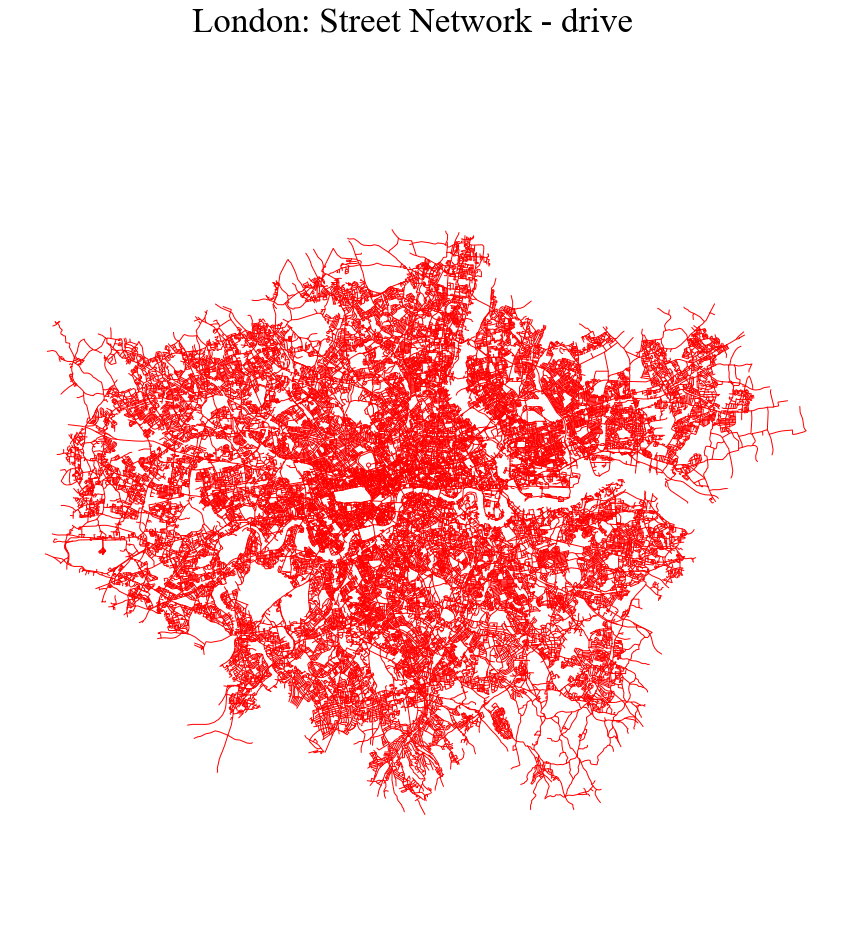

In [22]:
ci.plot_gdf(edges_graph, scheme = None, black_background = False, fig_size = 15, title = city_name+': Street Network - drive')

## District identification

In [ ]:
# Creating the dual geodataframes
nodesDual_graph, edgesDual_graph = ci.dual_gdf(nodes_graph, edges_graph, epsg)

nodesDual_graph.drop('intersecting', axis = 1).to_file(saving_path+city_name+"_nodesDual.shp", driver='ESRI Shapefile')
edgesDual_graph.to_file(saving_path+city_name+"_edgesDual.shp", driver='ESRI Shapefile')

In [ ]:
# creating dual_graph
dual_graph = ci.dual_graph_fromGDF(nodesDual_graph, edgesDual_graph)

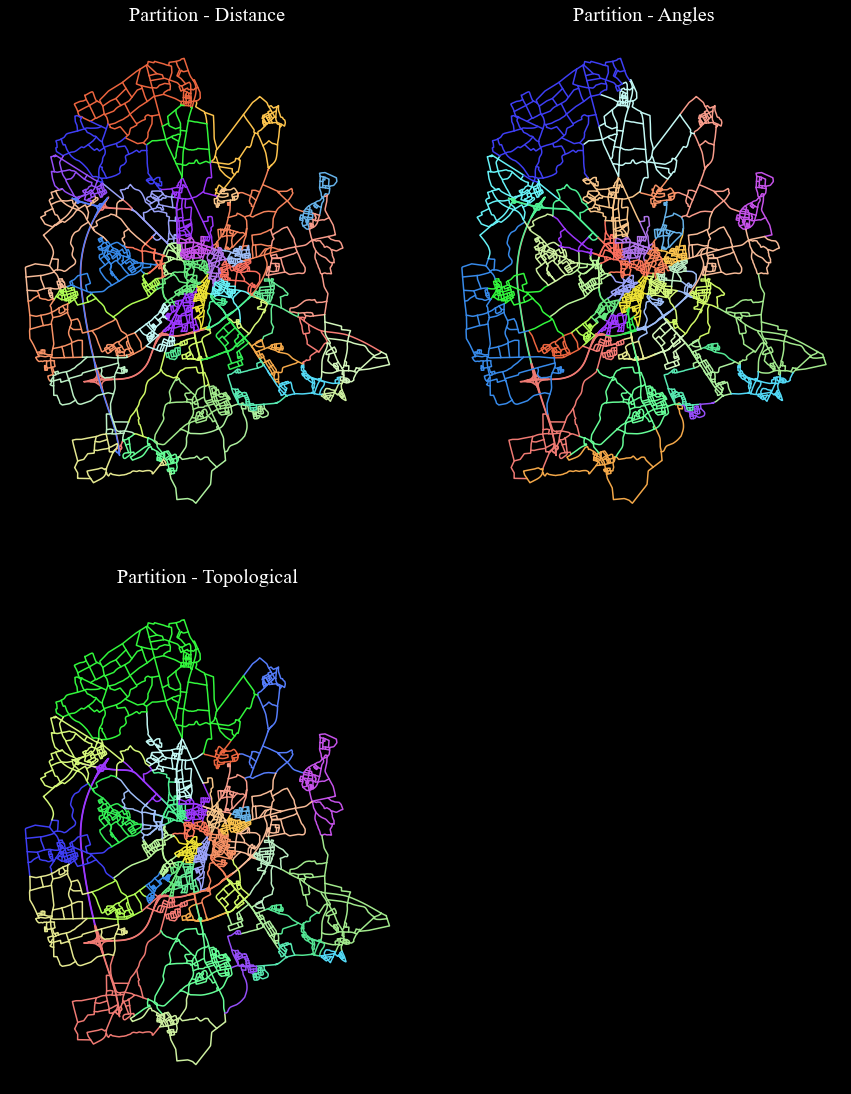

In [16]:
"""
Different weights are used to extract the partitions. "None" indicates that no weights will be used 
(only topological relationships will matter). The function returns a GeoDataFrame with partitions assigned to edges,
with column named as "p_name_weight" (e.g. "p_length")
 
"""
# weights = ['length', 'rad', None]
# districts = edges_graph.copy()
# for i in weights:
#     districts = ci.identify_regions(dual_graph, districts, weight = i)
    
# visualising
columns = ['p_length','p_rad', 'p_topo']
titles = ['Partition - Distance', 'Partition - Angles', 'Partition - Topological']

nlabels = max([len(districts[column].unique()) for column in columns])
cmap = ci.rand_cmap(nlabels = nlabels, type_color='bright')
fig = ci.plot_gdf_grid(districts, columns = columns, titles = titles, lw = 1.5, cmap = cmap, black_background = True, 
                  legend = False, fig_size = 15)

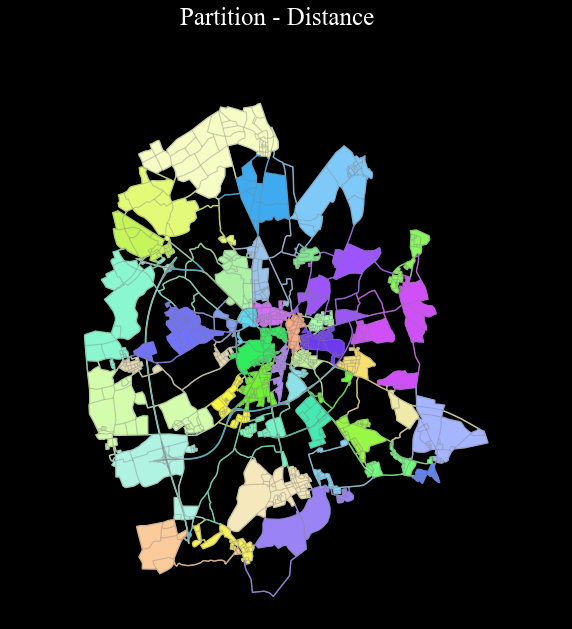

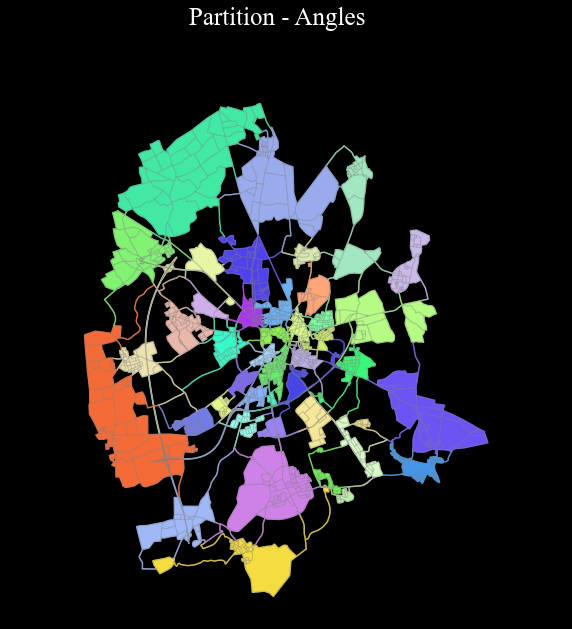

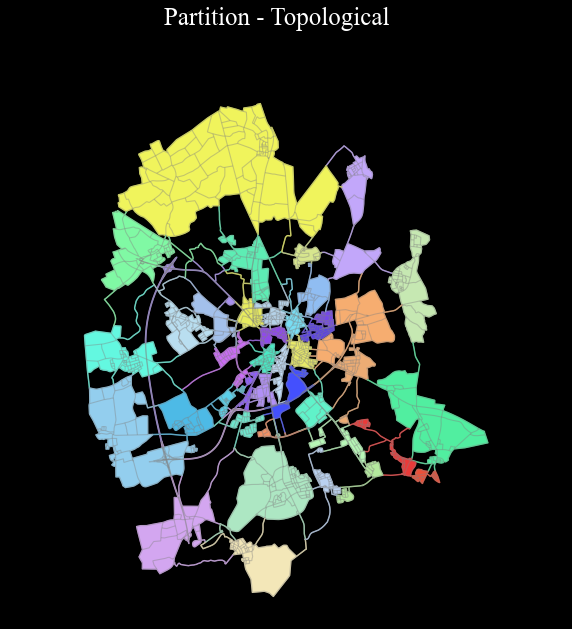

In [31]:
for n, column in enumerate(columns):
    cmap = ci.rand_cmap(nlabels = len(districts[column].unique()), type_color='bright')
    partitions = ci.polygonise_partition(districts, column, method = None) # method can be 'convex_hull'
    ci.plot_gdf(partitions, column = 'districtID', cmap = cmap, title =  titles[n], black_background = True,  fig_size = 10,
               gdf_base_map = districts, base_map_color = 'grey', base_map_zorder = 1)

In [33]:
# saving
districts.to_file(saving_path+city_name+"_edges.shp", driver='ESRI Shapefile')

## Case-study area (pedestrian walkable network)
### It should be ottained via notebook 01-Nodes_paths_web

In [15]:
input_path = 'Outputs/'+city_name+'/'
nodes_graph_ped = gpd.read_file(input_path+city_name+'_nodes.shp')
edges_graph_ped = gpd.read_file(input_path+city_name+'_edges.shp')

try:
    nodes_graph_ped, edges_graph_ped = nodes_graph_ped.to_crs(epsg=epsg), edges_graph_ped.to_crs(epsg=epsg)
except:
    nodes_graph_ped.crs, edges_graph_ped.crs = crs, crs

nodes_graph_ped.index, edges_graph_ped.index  = nodes_graph_ped.nodeID, edges_graph_ped.edgeID
nodes_graph_ped.index.name, edges_graph_ped.index.name  = None, None

### Otherwise, get it from OSM:

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *OSMpolygon*, provide an OSM polygon (relation) name.
* *distance_from_address*, provide a precise address and define parameter "distance" (which is otherwise not necessary)

In [ ]:
place = 'London, UK' ## must be different from the area used for the drive network
download_method = 'OSMplace'
distance = None

nodes_graph_ped, edges_graph_ped = ci.get_network_fromOSM(place, download_method, 'walk', epsg, distance = distance)
nodes_graph_ped, edges_graph_ped = ci.clean_network(nodes_graph_ped, edges_graph_ped, dead_ends = True, 
                                remove_disconnected_islands = True, self_loops = True, same_uv_edges = True)

### Visualise 

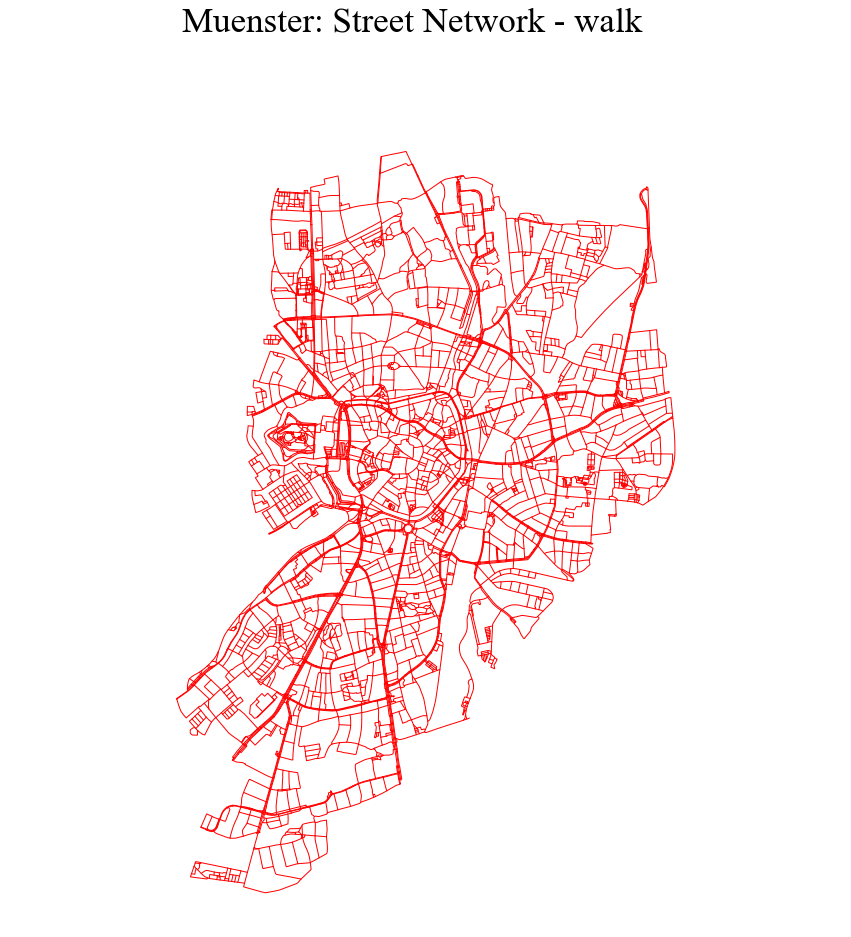

In [22]:
ci.plot_gdf(edges_graph_ped, black_background = False, fig_size = 15, title = city_name+': Street Network - walk')

In [ ]:
ci.plot_gdf(edges_graph_ped, scheme = None,  black_background = False, fig_size = 15, title = 
              city_name+': Entire Street Network vs Case-study area',
             gdf_base_map = edges_graph, base_map_color = 'black', base_map_alpha = 0.3)

## Assign nodes and edges in the pedestrian network to a partition

In [16]:
# choose type of partition you want to use
column = 'p_rad'
min_size_district = 10

dc = dict(edges_graph[column].value_counts())

## ignore small portions
to_ignore = {k: v for k, v in dc.items() if v <= min_size_district} 
tmp = edges_graph[~((edges_graph[column].isin(to_ignore))| (edges_graph['p_rad'] == 999999))].copy()

partitions = ci.polygonise_partition(tmp, column)
nodes_graph_ped['district'] = nodes_graph_ped.apply(lambda row: 
                                            ci.district_to_nodes_from_polygons(row['geometry'], partitions), axis = 1)
nodes_graph_ped['district'] = nodes_graph_ped.district.astype(int)

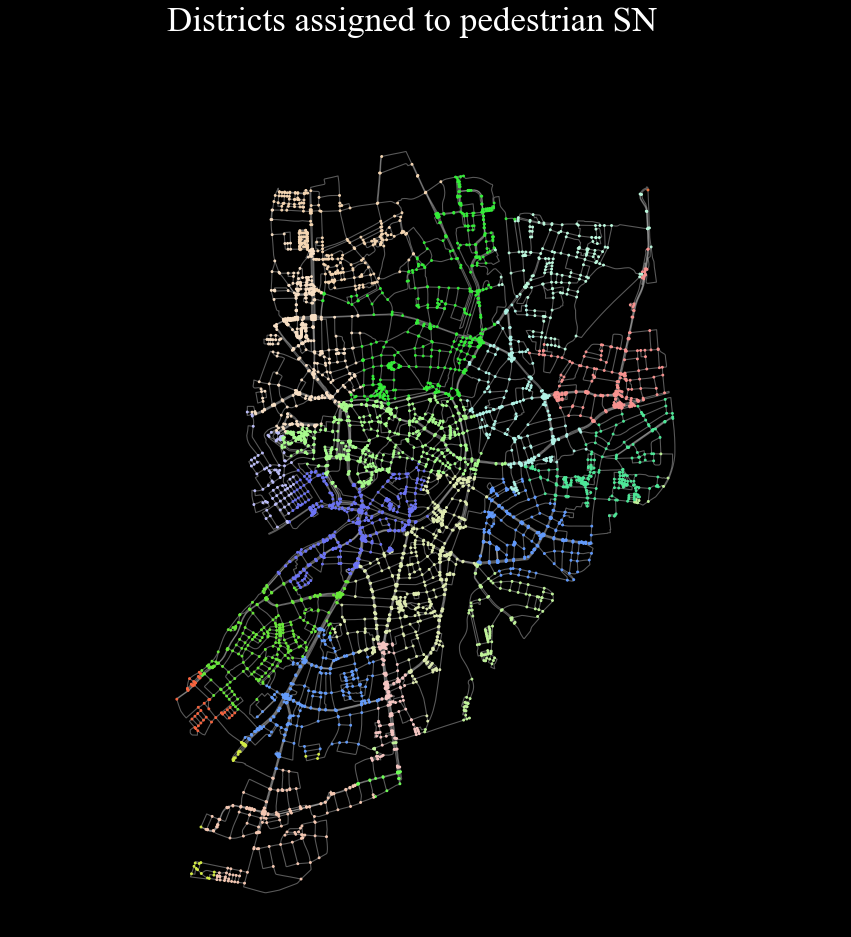

In [17]:
# visualisation
cmap = ci.rand_cmap(nlabels = len(nodes_graph_ped['district'].unique()), type_color='bright')
ci.plot_gdf(nodes_graph_ped, column = 'district', title = 'Districts assigned to pedestrian SN', cmap = cmap, ms = 3.5,
              gdf_base_map = edges_graph_ped, base_map_color = 'white', base_map_alpha = 0.35,
               black_background = True, legend = False, fig_size = 15)

In [19]:
# fixing disconnected districts and assigning nodes to existing connected districts
nodes_graph_ped = ci.check_disconnected_districts(nodes_graph_ped, edges_graph_ped, min_size_district)

while (999999 in nodes_graph_ped['district'].unique()):
    nodes_graph_ped['district'] = nodes_graph_ped.apply(lambda row: ci.amend_node_membership(row['nodeID'], nodes_graph_ped,
                                edges_graph_ped), axis = 1)
    nodes_graph_ped = ci.check_disconnected_districts(nodes_graph_ped, edges_graph_ped, min_size_district)
    
# assign gateways
nodes_graph_ped['gateway'] = nodes_graph_ped.apply(lambda row: ci.find_gateways(row['nodeID'], nodes_graph_ped, 
                                                                             edges_graph_ped), axis = 1)

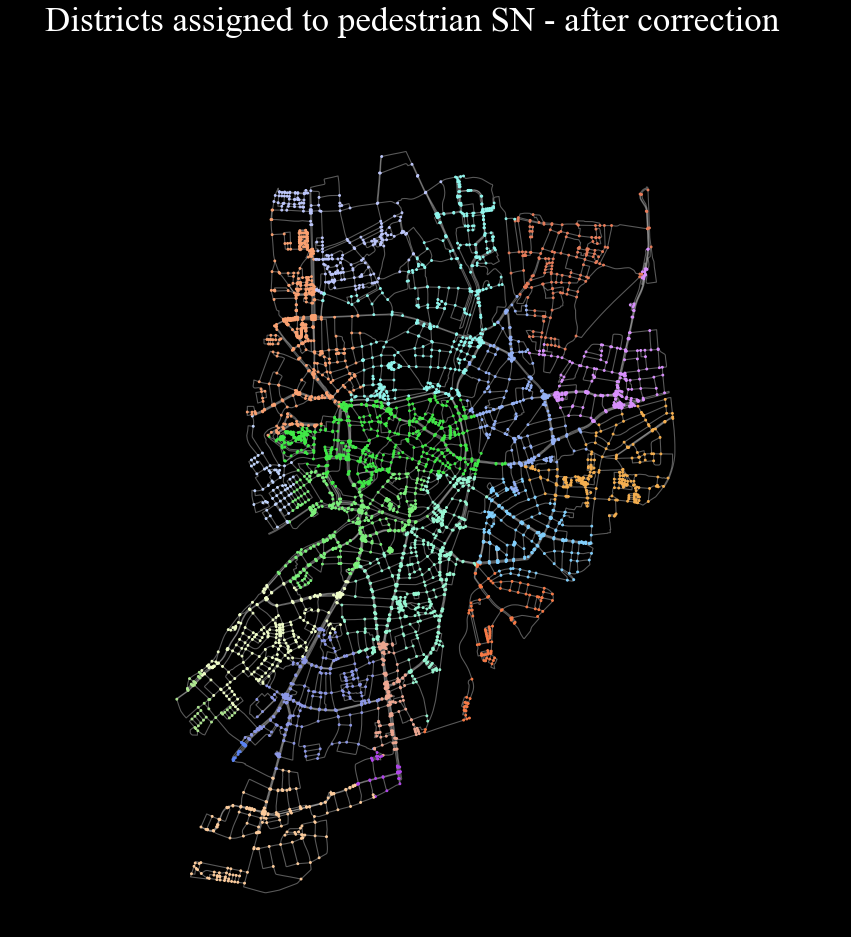

In [21]:
# visualise the final division
cmap = ci.rand_cmap(nlabels = len(nodes_graph_ped['district'].unique()), type_color='bright')
ci.plot_gdf(nodes_graph_ped, column = 'district', title = 'Districts assigned to pedestrian SN - after correction', 
               cmap = cmap, ms = 3.5, gdf_base_map = edges_graph_ped, base_map_color = 'white', base_map_alpha = 0.35,
               black_background = True, legend = False, fig_size = 15)

In [27]:
# saving
saving_path = 'Outputs/'+city_name+'/'
nodes_graph_ped.to_file(saving_path+city_name+"_nodes.shp", driver='ESRI Shapefile')
edges_graph_ped.to_file(saving_path+city_name+"_edges.shp", driver='ESRI Shapefile')